# Inference: Adaptive Covariance: localised MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc_remi.html) detailed in Algorithm 7 of [1], which involves using a vector of possible proposal distributions; which represent different modes of the distribution.

[1] A tutorial on adaptive MCMC
    Christophe Andrieu and Johannes Thoms, Statistical Computing,
    2008, 18: 343-373

It follows on from the [first sampling example](./sampling-first-example.ipynb).

# Fitting to the logistic model
Here localised MCMC with 3 proposal distributions is wasteful because there is only one mode.

In [1]:
import os
os.chdir('C:/Users/bclamber/Desktop/AllPints/pints4/pints')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 0.95,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceLocalisedMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Running...


C:\Users\bclamber\Desktop\AllPints\pints4\pints\pints\_mcmc\_adaptive_covariance.py:162: RuntimeWarning: overflow encountered in exp
  self._alpha = np.minimum(1, np.exp(r))


KeyboardInterrupt: 

# Multimodal posterior
Here localised adaptive MCMC does better than adaptive covariance samplers with only a single proposal distribution.

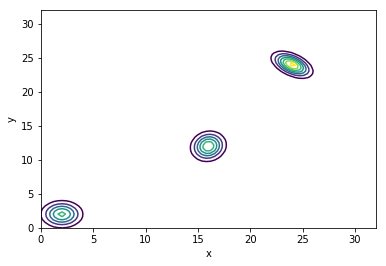

In [1]:
import os
os.chdir('C:/Users/bclamber/Desktop/AllPints/pints4/pints')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a multi-modal logpdf
log_pdf = pints.toy.MultimodalNormalLogPDF(
    [
        [2, 2],
        [16, 12],
        [24, 24],
    ],
    [
        [[1.2, 0.0], [0.0, 1.2]],
        [[0.8, 0.1], [0.1, 1.4]],
        [[1.0, -0.5], [-0.5, 1.0]],
    ]        
)
    
# Contour plot of pdf
x = np.linspace(0, 32, 80)
y = np.linspace(0, 32, 80)
X, Y = np.meshgrid(x, y)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Running...
hello
[  2.12781396e-12   1.00000000e+00   3.59979847e-16]
[ 14.82345218   9.59753734]
[array([ 2.,  2.]), array([ 15.22376792,  10.41496576]), array([ 24.,  24.])]
hello
[  1.52543117e-13   1.00000000e+00   9.72466975e-18]
[ 14.44396187   9.79957692]
[array([ 2.,  2.]), array([ 14.8203884 ,  10.09663628]), array([ 24.,  24.])]
Done!


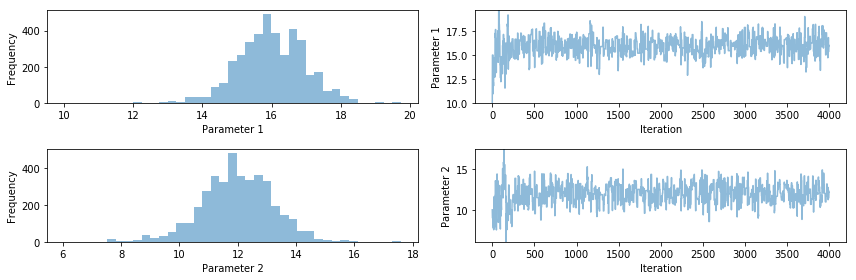

R-hat:


ZeroDivisionError: float division by zero

In [1]:
import os
os.chdir('C:/Users/bclamber/Desktop/AllPints/pints4/pints')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a multi-modal logpdf
log_pdf = pints.toy.MultimodalNormalLogPDF(
    [
        [2, 2],
        [16, 12],
        [24, 24],
    ],
    [
        [[1.2, 0.0], [0.0, 1.2]],
        [[0.8, 0.1], [0.1, 1.4]],
        [[1.0, -0.5], [-0.5, 1.0]],
    ]        
)

# Choose starting points for 3 mcmc chains
xs = [[10, 10]]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_pdf, 1, xs, method=pints.AdaptiveCovarianceLocalisedMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# Discard warm up
chains = chains[:, 2000:, :]

# Print Rhat
print('R-hat:')
print(pints.rhat_all_params(chains))

samples = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [2]:
samples = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'X' is not defined

In [3]:
import scipy

In [4]:
scipy.stats.multivariate_normal.logpdf()

AttributeError: 'multivariate_normal_gen' object has no attribute 'log'

In [11]:
np.random.choice(3, 100, p=[0, 1, 0])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [2]:
np.repeat(4 * np.identity(2), 3)

array([ 4.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  4.])

In [3]:
np.identity(2)

array([[ 1.,  0.],
       [ 0.,  1.]])